In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import Comparator, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## baseline

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_prop2", {"num_epochs": 2000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0., 1.0]})
pde_model.add_endogs(["q", "theta", "psi"], configs={
    "q": {
        "positive": True
    },
    "theta": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0.8", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\Phi = \frac{1}{\kappa} * (\sqrt{1+2 * \kappa * \iota} - 1)$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{(\psi - \eta) * \sigma}{\eta * (1-(\psi-\eta)*\frac{\partial q}{\partial \eta}/q)}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{1}{q} *\frac{\partial q}{\partial \eta} * \sigma_t^\eta * \eta$")
pde_model.add_equation(r"$\sigma_t^\theta = \frac{1}{\theta} * \frac{\partial \theta}{\partial \eta} * \sigma_t^\eta * \eta$")
pde_model.add_equation(r"$\mu_t^\eta = -\sigma_t^\eta  * (\sigma + \sigma_t^q + \sigma_t^\theta) + \frac{a-\iota}{q} + (1-\psi)*(\underline{\delta} - \delta)$")
pde_model.add_equation(r"$\mu_t^q = \frac{1}{q} * \left(\frac{\partial q}{\partial \eta} * \mu_t^\eta * \eta + \frac{1}{2} * \frac{\partial^2 q}{\partial \eta^2} * (\sigma_t^\eta)^2 * \eta^2 \right)$")
pde_model.add_equation(r"$\mu_t^\theta = \frac{1}{\theta} * \left(\frac{\partial \theta}{\partial \eta} * \mu_t^\eta * \eta + \frac{1}{2} * \frac{\partial^2 \theta}{\partial \eta^2} * (\sigma_t^\eta)^2 * \eta^2  \right)$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_constraint("q", Comparator.LEQ, "1.2")
pde_model.add_constraint("q_e", Comparator.GEQ, "0")
pde_model.add_constraint("theta_e", Comparator.LEQ, "0")
pde_model.add_endog_equation(r"$\frac{a-\underline{a}}{q} + \underline{\delta} - \delta + (\sigma + \sigma_t^q) * \sigma_t^\theta = 0$")
pde_model.add_endog_equation(r"$\mu_t^q = r - \frac{a - \iota}{q} - \Phi + \delta - \sigma * \sigma_t^q - \sigma_t^\theta * (\sigma + \sigma_t^q)$")
pde_model.add_endog_equation(r"$\mu_t^\theta = \rho - r$")

print(pde_model)
if not os.path.exists("./models/BruSan14_prop2/model.pt"):
    pde_model.train_model("./models/BruSan14_prop2", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_prop2/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_prop2/model_best.pt"))
    pde_model.eval_model(True)

========================Summary of Model BruSan14_prop2=========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "UniformRandom"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.0, 1.0]

=====================================Agents=====================================

=============================

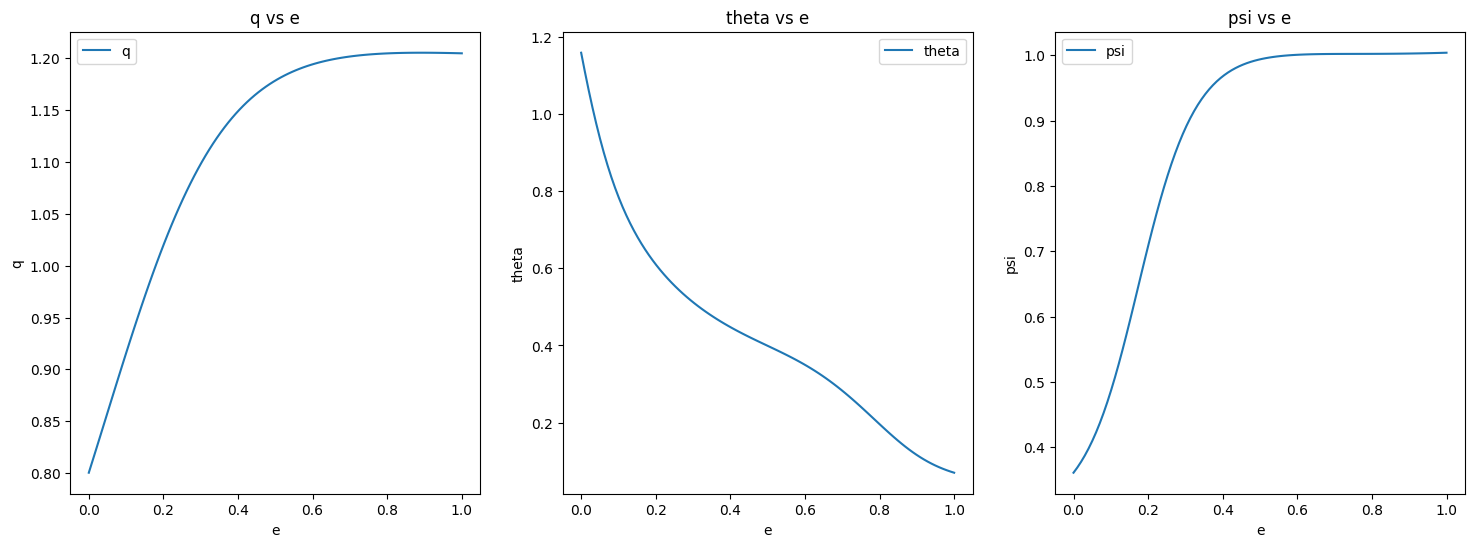

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
e = np.linspace(0, 1)
pde_model.endog_vars["q"].plot("q", {"e": [0, 1]}, ax=ax[0])
pde_model.endog_vars["theta"].plot("theta", {"e": [0, 1]}, ax=ax[1])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

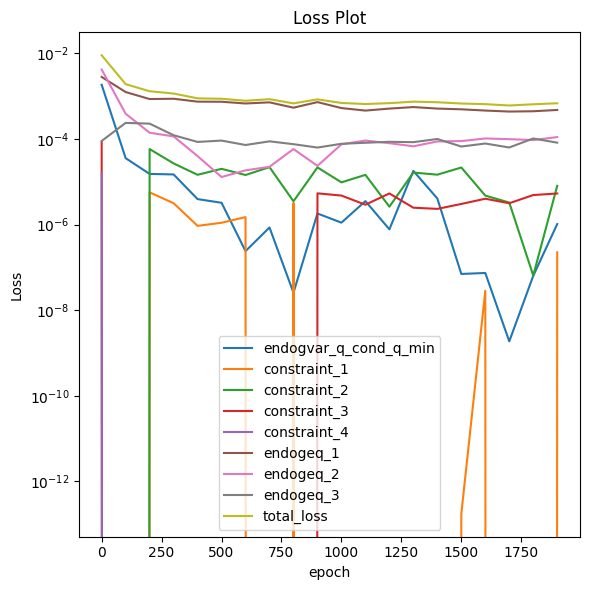

In [5]:
plot_loss_df(fn="./models/BruSan14_prop2/model_loss.csv", loss_plot_fn="./models/BruSan14_prop2/model_loss.jpg")

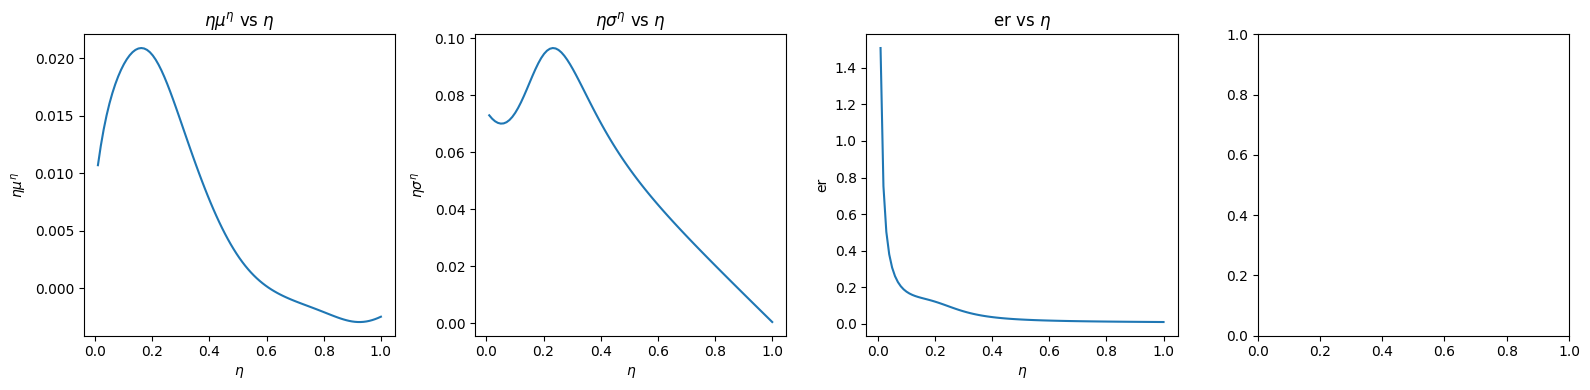

In [6]:
pde_model.plot_vars([r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"])

## RAR-G

========================Summary of Model BruSan14_prop2=========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "RAR-G"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.01, 0.99]

=====================================Agents=====================================

================================Age

Total loss: 0.0008: 100%|██████████| 2000/2000 [00:58<00:00, 34.23it/s]


training finished, total time :: 58.42955422401428
Best model saved to ./models/BruSan14_prop2/model_rarg_best.pt if valid
Model saved to ./models/BruSan14_prop2/model_rarg.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
constraint_2: 0.0000,
constraint_3: 0.0000,
constraint_4: 0.0000,
endogeq_1: 0.0004,
endogeq_2: 0.0001,
endogeq_3: 0.0001,
total_loss: 0.0006


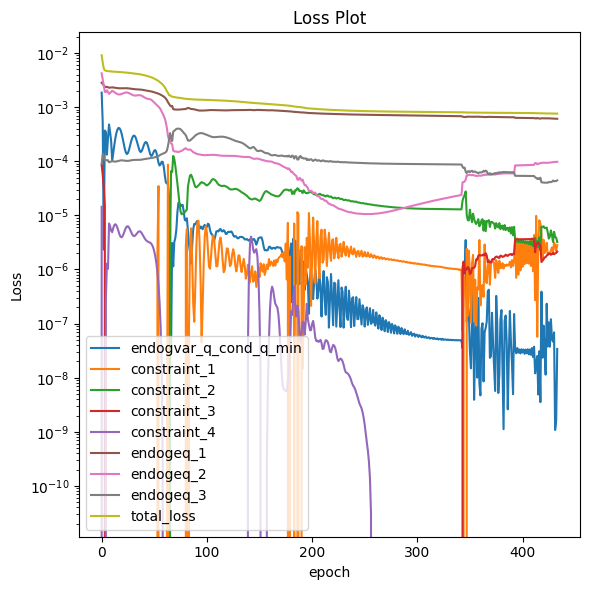

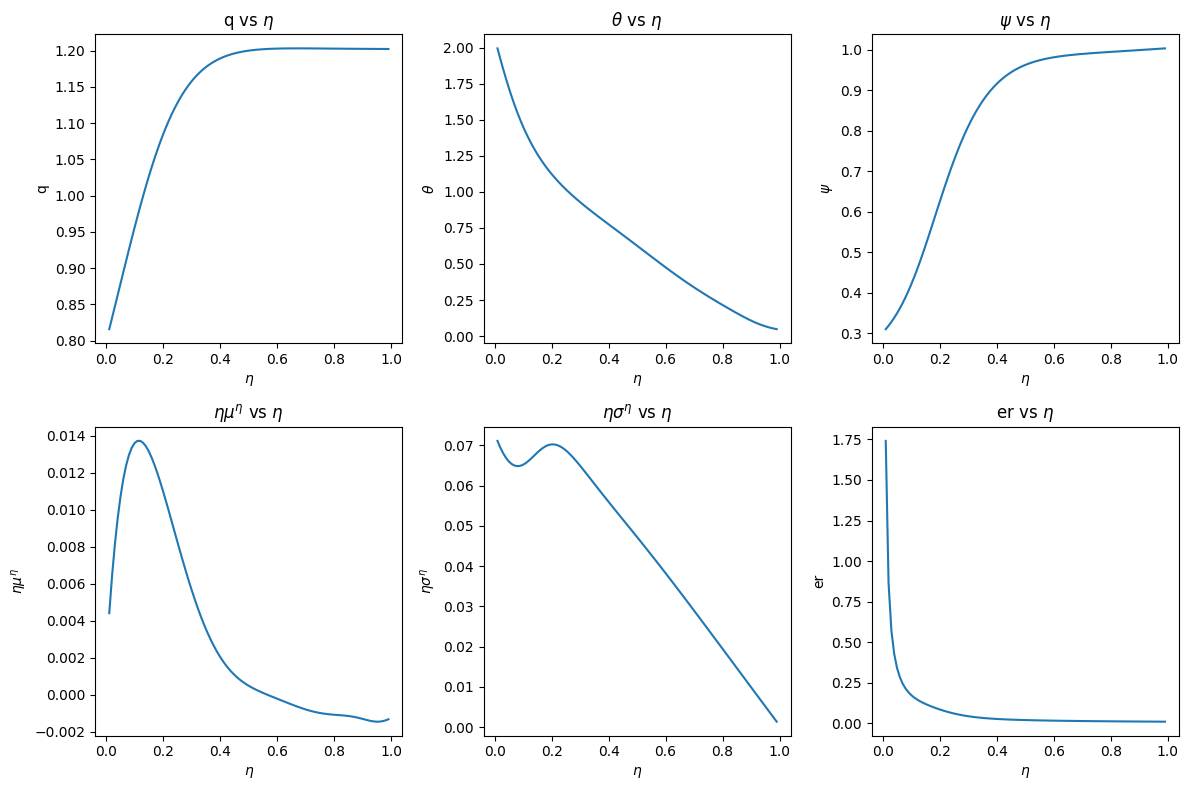

In [7]:
set_seeds(0)
pde_model = PDEModel("BruSan14_prop2", 
                     {"num_epochs": 2000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam,
                      "sampling_method": SamplingMethod.RARG}, 
                     latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "theta", "psi"], configs={
    "q": {
        "positive": True
    },
    "theta": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0.8", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\Phi = \frac{1}{\kappa} * (\sqrt{1+2 * \kappa * \iota} - 1)$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{(\psi - \eta) * \sigma}{\eta * (1-(\psi-\eta)*\frac{\partial q}{\partial \eta}/q)}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{1}{q} *\frac{\partial q}{\partial \eta} * \sigma_t^\eta * \eta$")
pde_model.add_equation(r"$\sigma_t^\theta = \frac{1}{\theta} * \frac{\partial \theta}{\partial \eta} * \sigma_t^\eta * \eta$")
pde_model.add_equation(r"$\mu_t^\eta = -\sigma_t^\eta  * (\sigma + \sigma_t^q + \sigma_t^\theta) + \frac{a-\iota}{q} + (1-\psi)*(\underline{\delta} - \delta)$")
pde_model.add_equation(r"$\mu_t^q = \frac{1}{q} * \left(\frac{\partial q}{\partial \eta} * \mu_t^\eta * \eta + \frac{1}{2} * \frac{\partial^2 q}{\partial \eta^2} * (\sigma_t^\eta)^2 * \eta^2 \right)$")
pde_model.add_equation(r"$\mu_t^\theta = \frac{1}{\theta} * \left(\frac{\partial \theta}{\partial \eta} * \mu_t^\eta * \eta + \frac{1}{2} * \frac{\partial^2 \theta}{\partial \eta^2} * (\sigma_t^\eta)^2 * \eta^2  \right)$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_constraint("q", Comparator.LEQ, "1.2")
pde_model.add_constraint("q_e", Comparator.GEQ, "0")
pde_model.add_constraint("theta_e", Comparator.LEQ, "0")
pde_model.add_endog_equation(r"$\frac{a-\underline{a}}{q} + \underline{\delta} - \delta + (\sigma + \sigma_t^q) * \sigma_t^\theta = 0$")
pde_model.add_endog_equation(r"$\mu_t^q = r - \frac{a - \iota}{q} - \Phi + \delta - \sigma * \sigma_t^q - \sigma_t^\theta * (\sigma + \sigma_t^q)$")
pde_model.add_endog_equation(r"$\mu_t^\theta = \rho - r$")

print(pde_model)
if not os.path.exists("./models/BruSan14_prop2/model_rarg.pt"):
    pde_model.train_model("./models/BruSan14_prop2", "model_rarg.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_prop2/model_rarg_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_prop2/model_rarg_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_prop2/model_rarg_min_loss.csv", loss_plot_fn="./models/BruSan14_prop2/model_rarg_min_loss.jpg")
pde_model.plot_vars(["q", r"$\theta$", r"$\psi$",
    r"$\eta\mu^\eta = \eta*\mu_t^\eta$", r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$", "er = psi/e*(sig+sigq)**2"], 3)

## RAR-D

========================Summary of Model BruSan14_prop2=========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "RAR-D"
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Variables=================================
e: [0.01, 0.99]

=====================================Agents=====================================

================================Age

Total loss: 0.0006: 100%|██████████| 2000/2000 [00:59<00:00, 33.42it/s]


training finished, total time :: 59.85568571090698
Best model saved to ./models/BruSan14_prop2/model_rard_best.pt if valid
Model saved to ./models/BruSan14_prop2/model_rard.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
constraint_2: 0.0000,
constraint_3: 0.0000,
constraint_4: 0.0000,
endogeq_1: 0.0004,
endogeq_2: 0.0002,
endogeq_3: 0.0001,
total_loss: 0.0006


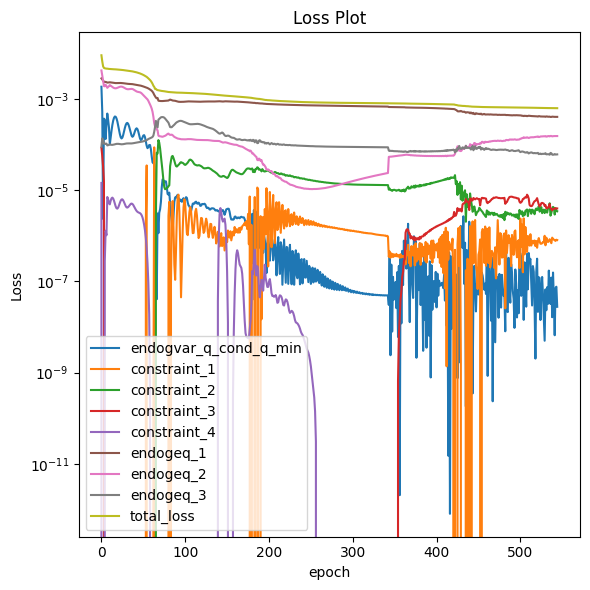

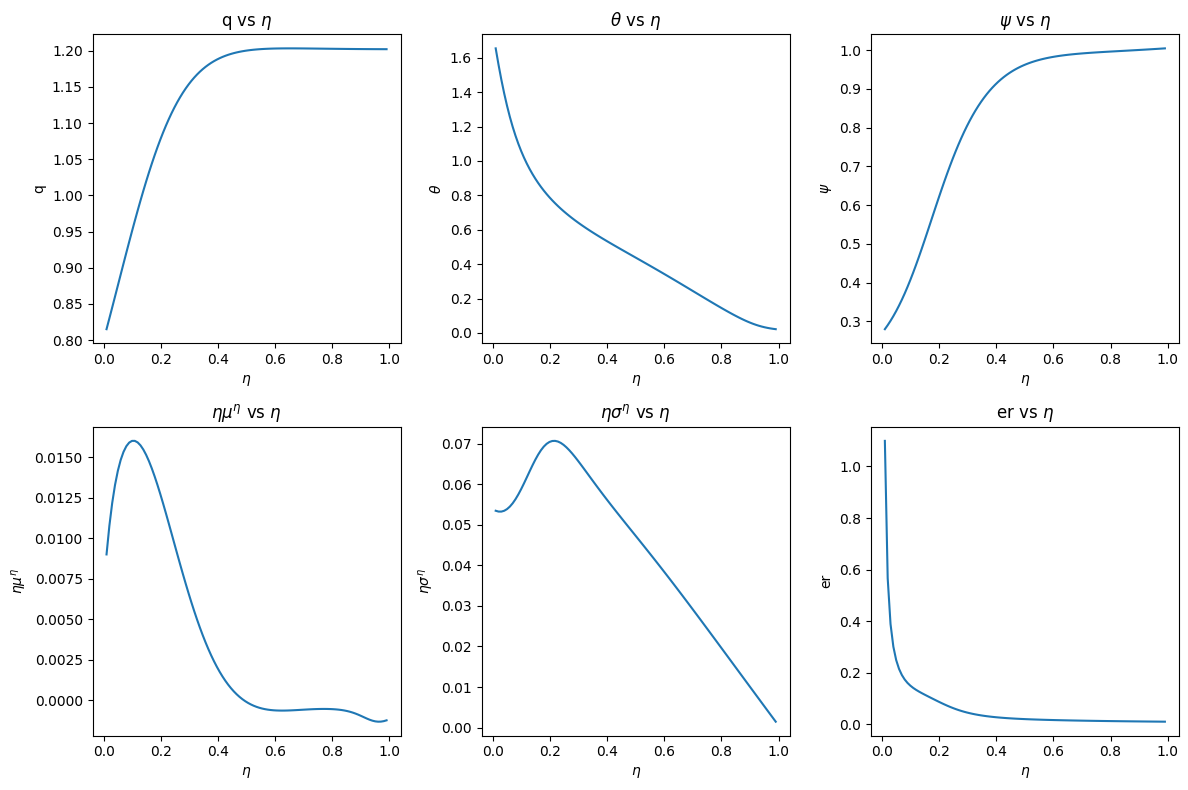

In [8]:
set_seeds(0)
pde_model = PDEModel("BruSan14_prop2", 
                     {"num_epochs": 2000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam,
                      "sampling_method": SamplingMethod.RARD}, 
                     latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "theta", "psi"], configs={
    "q": {
        "positive": True
    },
    "theta": {
        "positive": True
    },
    "psi": {
        "positive": True
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "0.8", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\Phi = \frac{1}{\kappa} * (\sqrt{1+2 * \kappa * \iota} - 1)$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{(\psi - \eta) * \sigma}{\eta * (1-(\psi-\eta)*\frac{\partial q}{\partial \eta}/q)}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{1}{q} *\frac{\partial q}{\partial \eta} * \sigma_t^\eta * \eta$")
pde_model.add_equation(r"$\sigma_t^\theta = \frac{1}{\theta} * \frac{\partial \theta}{\partial \eta} * \sigma_t^\eta * \eta$")
pde_model.add_equation(r"$\mu_t^\eta = -\sigma_t^\eta  * (\sigma + \sigma_t^q + \sigma_t^\theta) + \frac{a-\iota}{q} + (1-\psi)*(\underline{\delta} - \delta)$")
pde_model.add_equation(r"$\mu_t^q = \frac{1}{q} * \left(\frac{\partial q}{\partial \eta} * \mu_t^\eta * \eta + \frac{1}{2} * \frac{\partial^2 q}{\partial \eta^2} * (\sigma_t^\eta)^2 * \eta^2 \right)$")
pde_model.add_equation(r"$\mu_t^\theta = \frac{1}{\theta} * \left(\frac{\partial \theta}{\partial \eta} * \mu_t^\eta * \eta + \frac{1}{2} * \frac{\partial^2 \theta}{\partial \eta^2} * (\sigma_t^\eta)^2 * \eta^2  \right)$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_constraint("q", Comparator.LEQ, "1.2")
pde_model.add_constraint("q_e", Comparator.GEQ, "0")
pde_model.add_constraint("theta_e", Comparator.LEQ, "0")
pde_model.add_endog_equation(r"$\frac{a-\underline{a}}{q} + \underline{\delta} - \delta + (\sigma + \sigma_t^q) * \sigma_t^\theta = 0$")
pde_model.add_endog_equation(r"$\mu_t^q = r - \frac{a - \iota}{q} - \Phi + \delta - \sigma * \sigma_t^q - \sigma_t^\theta * (\sigma + \sigma_t^q)$")
pde_model.add_endog_equation(r"$\mu_t^\theta = \rho - r$")

print(pde_model)
if not os.path.exists("./models/BruSan14_prop2/model_rard.pt"):
    pde_model.train_model("./models/BruSan14_prop2", "model_rard.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_prop2/model_rard_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_prop2/model_rard_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_prop2/model_rard_min_loss.csv", loss_plot_fn="./models/BruSan14_prop2/model_rard_min_loss.jpg")
pde_model.plot_vars(["q", r"$\theta$", r"$\psi$",
    r"$\eta\mu^\eta = \eta*\mu_t^\eta$", r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$", "er = psi/e*(sig+sigq)**2"], 3)